/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


44 :: 8


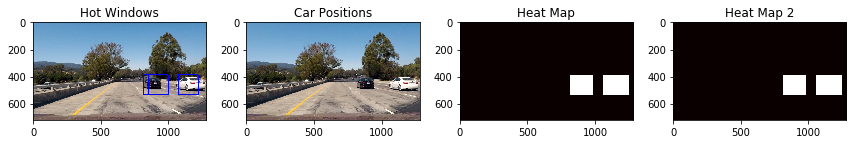

0 :: 7


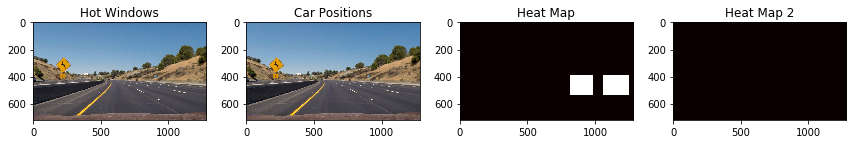

2 :: 2


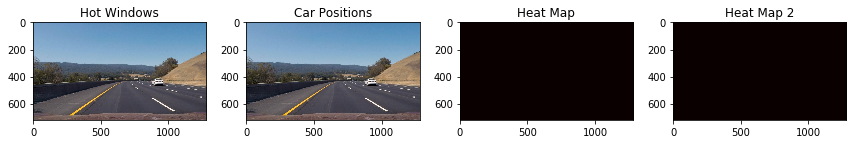

61 :: 7


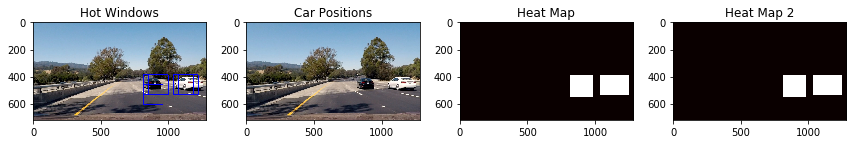

33 :: 5


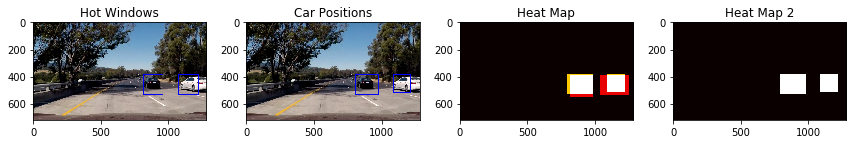

50 :: 9


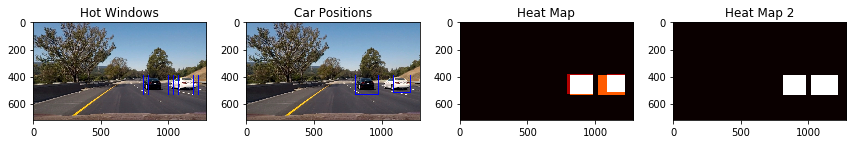

In [5]:
%run 'vehicle_detection.py'

svc_file = "./classifier.p"
svc = pickle.load(open(svc_file, "rb" ))

scaler_file = "./scaler.p"
X_scaler = pickle.load(open(scaler_file, "rb" ))

global_heat = FrameHeatMap((720, 1280))

start_scale = 1.3
end_scale = 2.4
step_scale = 0.25
def process_image(image, debug=False):
    bboxes = []
    curr_scale = start_scale
    rand_offset = random.randint(0, 10)
    while curr_scale < end_scale:
        out_img = image.copy().astype(np.float32)
        out_img, heatmap, hot_windows = find_cars(out_img, ystart=Settings.y_start_stop[0]+rand_offset, \
                            ystop=Settings.y_start_stop[1], scale=curr_scale, svc=svc, \
                            X_scaler=X_scaler, orient=Settings.orient, pix_per_cell=Settings.pix_per_cell, \
                            cell_per_block=Settings.cell_per_block, spatial_size=Settings.spatial_size, \
                            hist_bins=Settings.hist_bin, \
                            color_space=Settings.color_space, hog_resize=Settings.hog_resize, \
                            cells_per_step=Settings.cells_per_step)
        bboxes.extend(hot_windows)
        curr_scale += step_scale
    
    print(len(bboxes), "::", rand_offset)
    heatmap_final = np.zeros_like(image[:,:,0]).astype(np.float32)
    heatmap_final = add_heat(heatmap_final, bboxes)
    heatmap_final = apply_threshold(heatmap_final, 1)
    heatmap_final = np.clip(heatmap_final, 0, 255)
    labels = label(heatmap_final)
    
    global global_heat
    heatmap_final[:] = 0
    draw_img, car_bboxes = draw_labeled_bboxes(image.copy(), labels)
    heatmap_final = add_heat(heatmap_final, car_bboxes)
    draw_img = global_heat.update(image, heatmap_final, labels, threshold=2)
    '''
    heatmap_update = apply_threshold(global_heat.heatmap.copy(), 3)
    labels = label(heatmap_update)
    draw_img, _ = draw_labeled_bboxes(image.copy(), labels)
    '''
    
    if debug:
        draw_img = draw_img.astype(np.uint8)
        out_img = out_img.astype(np.uint8)
        return draw_img, out_img, global_heat.heatmap, heatmap_final
    else:
        draw_img = draw_img.astype(np.uint8)
        return draw_img

test_images = glob.glob('../test_images/*.jpg')
for image_file in test_images:
    image = mpimg.imread(image_file).astype(np.float32)
    
    d_img, w_img, h_img, h_img2 = process_image(image, True)
    
    fig = plt.figure(figsize=(12,9))
    plt.subplot(141)
    plt.imshow(w_img)
    plt.title('Hot Windows')
    plt.subplot(142)
    plt.imshow(d_img)
    plt.title('Car Positions')
    plt.subplot(143)
    plt.imshow(h_img, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.subplot(144)
    plt.imshow(h_img2, cmap='hot')
    plt.title('Heat Map 2')
    fig.tight_layout()

    #plt.imshow(window_img)
    plt.show()